# 1 Dataset arrangement

In [1]:
import os
import sys
from zipfile import ZipFile
import struct
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## 1.1 Download and decompress dataset

“ETL Character Database” was downloaded from the website  (http://etlcdb.db.aist.go.jp/). In this study, "ETL-8G" datasest was used.

The dataset was provided compressed in a zip file. Decompress the zip file, then transform binary data to a usable format. File specification is provided at "http://etlcdb.db.aist.go.jp/specification-of-etl-8".

In [3]:
DATA_PATH = "drive/My Drive/" # location of the file
RECORD_SIZE = 8199
images = []
labels = []

with ZipFile(DATA_PATH + "ETL8G.zip") as etl1:
    names = [n for n in etl1.namelist() if "_" in n] #obtain file names in the zip file
    for x in names:
        with etl1.open(x) as f: #access binary file-like object
            while True:
                s = f.read(RECORD_SIZE) #Read and return up to size bytes
                if (s is None) or (len(s) < RECORD_SIZE):
                    break
                r = struct.unpack(">HH8sIBBBBHHHHBB30x8128s11x", s) # Interpret packed binary data, format: http://etlcdb.db.aist.go.jp/etlcdb/etln/form_e8g.htm
                img = Image.frombytes("F", (128, 127), r[14], "bit", (4, 0)) # F:32-bit floating point pixels, 128(X-axis size) * 127(Y-axis size), 16 Gray Level (4bit/pixel)
                img = np.array(img.convert("L"))  # "L" for greyscale
                lbl = r[1] # JIS Kanji Code (JIS X 0208) in decimal
                # if lbl in range(int(0x2420), int(0x2474)):  # used when extract only "Hiragana"
                images.append(img)
                labels.append(lbl)

## 1.2 Change labels into Unicode

The labels were in JIS X 0208 format in decimal. With a conversion table, Convert the labels to Unicode. https://unicode.org/Public/MAPPINGS/OBSOLETE/EASTASIA/JIS/JIS0208.TXT

Make JIS X 0208-UTF16 dictionary with values in hexadecimal.

In [4]:
ar = []
with open(DATA_PATH +"JIS0208.txt") as f:  #conversion table
    for t_line in f:
        if t_line[0] != "#":
            sjis, jis, utf16 = os.path.basename(t_line).split("\t")[0:3]
            ar.append([jis, utf16])
ar = dict(ar) # "jis: utf16" dictionary

Decoder: JIS X 0208 in decimal to Unicode

In [5]:
def decoder(x):
    x = str(hex(x))[2:] # JIS X 0208: Decimal to Hexadecimal, remove first 2 '0x' for making the rest upper case later
    return int(ar["0x"+x.upper()], 16) # look up JIS X in Hex in the dctionary, onvertc reterned UTF-16 to Unicode

Convert data labels in JIS to in Unicode.

In [6]:
labels = list(map(decoder, labels))

## 1.3 Check data

Check data size

In [7]:
# check data size
print(len(images), len(labels))

153916 153916


Number of each classes

In [8]:
counts = np.bincount(labels)
counts = counts[counts>0]

print(len(counts), counts.max(), counts.min())

956 161 161


(total 956 classes with 161 samples each.)

Show examples of each character image and label

In [ ]:
!pip install japanize-matplotlib # to show Japanese in matplotlib

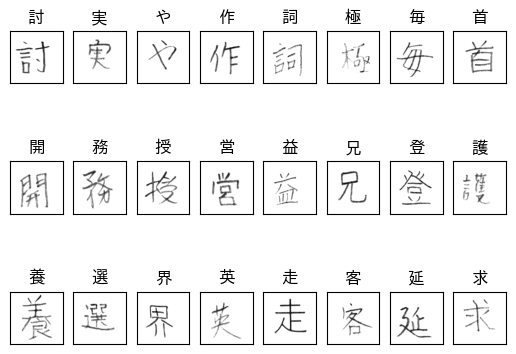

In [13]:
import japanize_matplotlib
perm = np.random.permutation(range(len(images)))
for k in range(24):
    plt.subplot(3, 8, k+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images[perm[k]], cmap="gray_r") # reverse gray scale
    plt.title(chr(labels[perm[k]]))
plt.show()

Make images and labels into numpy array

In [14]:
images = np.array(images)
labels = np.array(labels)

Show data shape

In [15]:
print(images.shape, labels.shape)

(153916, 127, 128) (153916,)


## 1.4 Change labels for deep-learning purposes

transform labels into index numbers, then one-hot vectorization.

Assign index to the labels.

In [16]:
classes = list(np.unique(labels))
indices = list(range(len(classes)))

class_dic =  dict(zip(classes, indices)) # label-index dictionary

def class_encode(x): # encoder
  return class_dic[x]

def class_decode(x): # decoder
  for k,v in class_dic.items():
    if x == v:
      return k

labels_index = list(map(class_encode, labels)) # indexed label list

In [ ]:
# save label-index dictionary for later use

import pickle

with open('./class_dic.pickle', mode='wb') as f:
    pickle.dump(class_dic,f)


# with open('./class_dic.pickle', mode='rb') as f:
#     data = pickle.load(f)

One-hot vectorization

In [17]:
from tensorflow.keras.utils import to_categorical

labels_one_hot = to_categorical(labels_index)

# 2. Create TFRecords

## 2.1 Separate the dataset into three (Training, Validation and test datasets)

shuffle the dataset

In [18]:
p = np.random.permutation(len(images))
images_data = images[p]
labels_data = labels_one_hot[p]

Separate the dataset. The training and validation dataset contains 10,000 samples each. Remains samples were for training.

In [19]:
image_test, image_validation, image_train = np.split(images_data, [10000, 20000])
label_test, label_validation, label_train = np.split(labels_data, [10000, 20000])

In [20]:
print(image_test.shape, image_validation.shape, image_train.shape)
print(label_test.shape, label_validation.shape, label_train.shape)

(10000, 127, 128) (10000, 127, 128) (133916, 127, 128)
(10000, 956) (10000, 956) (133916, 956)


In [23]:
print(max(images[0].reshape(-1)))

9


## 2.2 Create TFRecords

In [ ]:
import numpy as np
import tensorflow as tf

# Function to make FloatList Feature
def feature_float_list(l):
    return tf.train.Feature(float_list=tf.train.FloatList(value=l))

# Function to make Example
def array2example(image, label):
    feature = {
        "image": feature_float_list(image.reshape(-1).astype("float32")/16), # normalization by divided by 16: the images were in 16 Gray Level
        "label": feature_float_list(label.reshape(-1).astype("float32"))
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

Write records

In [ ]:
# filepath = "/content/drive/My Drive/956_test.tfrecord"
# filepath = "/content/drive/My Drive/956_val.tfrecord"
# filepath = "/content/drive/My Drive/956_train.tfrecord"

In [ ]:
with tf.io.TFRecordWriter(filepath) as writer:
  for image, label in zip(image_train, label_train):
    example_proto = array2example(image, label)
    writer.write(example_proto.SerializeToString())

## 2.3 Make "training + validation" records

Make "training + validation" records from train and validation TFRecord created.

In [ ]:
# https://copyprogramming.com/howto/how-can-i-merge-multiple-tfrecords-file-into-one-file

dir1 = "/content/drive/My Drive/956_train.tfrecord"
dir2 = "/content/drive/My Drive/956_validation.tfrecord"

list_of_tfrecord_files = [dir1, dir2]
dataset = tf.data.TFRecordDataset(list_of_tfrecord_files)
# Save dataset to .tfrecord file
filename = 'train_validation.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(dataset)

# 3. Load TFRecords

In [ ]:
# Locations of TFRecords (google cloud in this case)

filepath_train = 'gs://sabiko_project/956_train.tfrecord'
filepath_val = 'gs://sabiko_project/956_val.tfrecord'
filepath_test = 'gs://sabiko_project/956_test.tfrecord'
filepath_train_val = 'gs://sabiko_project/956_train_validation.tfrecord'

In [ ]:
batch_size = 1024
AUTOTUNE = tf.data.AUTOTUNE

def parse_batch_example(example):
    features = tf.io.parse_example(example, features={
        "image": tf.io.FixedLenFeature([127, 128, 1], dtype=tf.float32),
        "label": tf.io.FixedLenFeature([956,], dtype=tf.float32)
    })
    x = features["image"]
    y = features["label"]
    return x, y

dataset_train = tf.data.TFRecordDataset(filepath_train, num_parallel_reads=AUTOTUNE).shuffle(1000).batch(batch_size).map(parse_batch_example).prefetch(AUTOTUNE)
dataset_val = tf.data.TFRecordDataset(filepath_val, num_parallel_reads=AUTOTUNE).shuffle(1000).batch(batch_size).map(parse_batch_example).prefetch(AUTOTUNE)
dataset_test = tf.data.TFRecordDataset(filepath_test, num_parallel_reads=AUTOTUNE).shuffle(1000).batch(batch_size).map(parse_batch_example).prefetch(AUTOTUNE)
dataset_train_val = tf.data.TFRecordDataset(filepath_train_val, num_parallel_reads=AUTOTUNE).shuffle(1000).batch(batch_size).map(parse_batch_example).prefetch(AUTOTUNE)